# RISM - A Gentle Introduction

## Preamble

The code we've written so far:

In [1]:
import numpy as np
from scipy.fftpack import dstn, idstn
from scipy.special import erf
import matplotlib.pyplot as plt

# Constants
ec = 1.602176565e-19 # A*s
eps_0 = 8.854187817620e-12 # A^2*s^4/kg/m^3
Na = 6.02214129e23 # 1 / mol
kc = 1.0 / 4.0 / np.pi/ eps_0 # J*m/A^2/s^2
kc_a = kc * 1e10 # J*angstrom/A^2/s^2
kc_akj = kc_a * 1e-3 # kJ*angstrom/A^2/s^2
kc_akjmol = kc_akj * Na # kJ*angstrom/A^2/s^2/mol
lb = ec * ec * kc_akjmol # kJ*angstrom/mol

r = 15.0
N = 100
dr = r / N
dk = 2.0 * np.pi / (2.0 * N * dr)

r_grid = np.arange(0.5, N, 1.0) * dr
k_grid = np.arange(0.5, N, 1.0) * dk

def dist_matrix(coords):
    ns = len(coords)
    dist = np.zeros((ns, ns))
    for i, j in np.ndindex((ns, ns)):
        dist[i, j] = np.linalg.norm(coords[i] - coords[j])
    return dist

def wk(coords, k, N, ns):
    dists = dist_matrix(coords, ns)
    out = np.zeros((N, ns, ns))
    for i, j in np.ndindex((ns, ns)):
        dist_ij = dists[i, j]
        if dist_ij == 0.0:
            out[:, i, j] = np.ones(N)
        else:
            out[:, i, j] = np.sin(k * dist_ij) / (k * dist_ij)
    return out


def LJ(epsilon, sigma, r):
    return 4.0 * epsilon * ( np.power( (sigma / r), 12) - np.power( (sigma / r), 6) )

def Coulomb(q, r):
    return lb * q / r

def Ng_real(q, r):
    return lb * q * erf(r) / r

def Ng_fourier(q, k):
    return 4.0 * np.pi * lb * q * np.exp(-np.power(k, 2.0) / 4.0) / np.power(k, 2.0)

def lorentz_berthelot(eps1, eps2, sig1, sig2):
    return np.sqrt(eps1 * eps2), 0.5 * (sig1 + sig2)

def energy(params, r, N, ns):
    out = np.zeros((N, ns, ns))
    for i, j in np.ndindex((ns, ns)):
        eps, sig = lorentz_berthelot(
            params[i][0], params[j][0], params[i][1], params[j][1]
        )
        q = params[i][2] * params[j][2]
        out[:, i, j] = LJ(eps, sig, r) + Coulomb(q, r)

    return out

def renorm(params, r, k, N, ns):
    out_r = np.zeros((N, ns, ns))
    out_k = np.zeros((N, ns, ns))
    for i, j in np.ndindex((ns, ns)):
        q = params[i][2] * params[j][2]
        out_r[:, i, j] = Ng_real(q, r)
        out_k[:, i, j] = Ng_fourier(q, k)

    return out_r, out_k

def HNC(beta, ur, tr):
    return np.exp(-beta * ur + tr) - 1.0 - tr

def PY(beta, ur, tr):
    return np.exp(-beta * ur) * (1.0 + tr) - 1.0 - tr

def fbt(fr, r, k, dr):
    return 2.0 * np.pi * dr * dstn(fr * r[:, np.newaxis, np.newaxis], type=4, axes=[0]) / k[:, np.newaxis, np.newaxis]

def ifbt(fk, r, k, dk):
    return dk / 4.0 / np.pi / np.pi * idstn(fk * k[:, np.newaxis, np.newaxis], type=4, axes=[0]) / r[:, np.newaxis, np.newaxis]

def RISM(cr, vk_lr, w, p, r, k, dr, dk):
    N = r.shape[0]
    
    I = np.eye(w.shape[1])
    tk = np.zeros_like(cr)
    # Transform c(r) to c(k)
    ck = fbt(cr, r, k, dr)

    ck -= vk_lr

    # Solve the RISM equation for t(k)
    for l in np.arange(0, N):
        A = np.linalg.inv(I - p @ w[l] @ ck[l])
        B = w[l] @ ck[l] @ w[l]
        tk[l] = A @ B - ck[l]
    
    tk -= vk_lr
    
    # Transform t(k) to t(r)
    tr = ifbt(tk, r, k, dk)
    return tr

def picard_iteration(tolerance, max_step, alpha, initial_tr, beta, ur_sr, uk_lr,  wk, rho):
    # Set up our loop variable tr
    tr = initial_tr
    
    # Define our counter
    step = 0
    
    while True:
        # Store previous t(r)
        tr_prev = tr

        # t(r) -> c(r) from closure
        cr = HNC(beta, ur_sr, tr)

        # c(r) -> F(t(r)) from RISM equation
        f_tr = RISM(cr, beta * uk_lr, wk, rho, r_grid, k_grid, dr, dk)

        # Use Picard iteration to get the new solution
        # Since we set alpha = 1.0 above, this is 
        # essentially direct iteration (tr_new = f_tr).
        tr_new = alpha * f_tr + (1.0 - alpha) * tr_prev

        # Check the absolute value of the difference between the current and previous solution
        # We use .max() because we want to check that all values are below the tolerance, and
        # if the maximum value of the difference array is below, then so must the other values be.
        diff = np.sqrt(np.power((tr_new - tr_prev), 2).sum() * dr)

        # Set t(r) to the new t(r) we just computed
        tr = tr_new

        # Print the iteration step every 100 steps and difference
        if step % 100 == 0:
            print("Iteration: {step} Diff: {diff:.2e}".format(step=step, diff=diff))

        # Test if the difference is below our tolerance
        if diff < tolerance:
            print("Final Iteration: {step} Diff: {diff:.2e}".format(step=step, diff=diff))
            break
        
        # If we reach max_step, raise an error!
        if step == max_step:
            print("Reached max steps!")
            break

        if np.any(np.isnan(tr)):
            print("Diverged at iteration: {step}".format(step=step))
            break

        # Update our step counter. We have a max_step because we don't want this calculation to go 
        # on forever and freeze our PC.
        step += 1
    
    # Return solved t(r)
    return tr

We have the code to solve neat molecular liquid problems. A type of problem we're interested in how solute affects the solvent density. This problem is a relatively straightforward continuation of what we've already implemented.

First thing we do is define our solvent parameters.

In [2]:
T = 298.15 # Kelvin
kB = 8.314462618e-3 # kJ / mol / K
beta = 1.0 / T / kB # Thermodynamic Beta

nsv = 3

ow_eps = 78.15 * kB
ow_sigma = 3.16572
ow_charge = -0.8476

hw_eps = 7.815 * kB
hw_sigma = 1.16572
hw_charge = 0.4238

dens = 0.0334
rho = np.diag([dens, dens, dens])

water_params = [ [ow_eps, ow_sigma, ow_charge], [hw_eps, hw_sigma, hw_charge], [hw_eps, hw_sigma, hw_charge] ]
water_coords = [ np.array([0.0, 0.0, 0.0]), np.array([1.0, 0.0, 0.0]), np.array([-0.333314, 0.942816, 0.0])]

Actually, looking at the hydrogens, we can see from their interaction parameters (the Lennard-Jones parameter and the charge), they're essentially equivalent. We could make use of this fact and reduce the problem to only consider unique sites. We look at the multiplicity of each site and account for that multiplicty in the intramolecular correlation function, but otherwise we take it out of the other functions.

We can calculate the symmetry-reduced intramolecular correlation function $$w_{JL}(k) = \frac{1}{n_J} \sum_{j \in J}\omega_{jl}(k) = \frac{1}{n_L} \sum_{l \in L}\omega_{jl}(k) = w_{JL}(k)$$ 

where J and L are indices over the unique sites in the molecule. So far water, there are 2 unique sites - oxygen and hydrogen - but the hydrogen as 2 sites associated with it (a multiplicity of 2). We sum over those 2 sites and divide by 2 to get the symmetry-reduced element of the intramolecular correlation.

The only other modification is the symmetry-reduced direct correlation function $$C_{JL}(k) = n_J c_{jl}(k) n_L$$

First we need to define a reduced set of solvent parameters and introduce a diaganol matrix with the multiplicities along the diagonal - 1 for oxygen and 2 for hydrogen.


In [3]:
nsv = 2

water_mult = np.diag([1.0, 2.0])
water_params = [ [ow_eps, ow_sigma, ow_charge], [hw_eps, hw_sigma, hw_charge] ]
rho = np.diag([dens, dens])

Then we refactor the `wk` function to account for multiplicities. This is simply done by tracking the multiplicty for one of the indices, either `i` or `j`. In this implementation I choose to track `j`.

In [4]:
def wk(coords, multiplicity, k, N, ns):
    dist = dist_matrix(coords)
    out = np.zeros((N, ns, ns))
    for i, j in np.ndindex((ns, ns)):
        dists = []
        mult_j = int(multiplicity[j, j])
        dists.append(dist[i, j])
        if mult_j > 1:
            for mj in range(1, mult_j):
                dists.append(dist[i, j + mj])
        for dist_ij in dists:
            if dist_ij < 0.0:
                out[:, i, j] += np.zeros(N)
            elif dist_ij == 0.0:
                out[:, i, j] += np.ones(N)
            else:
                out[:, i, j] += np.sin(k * dist_ij) / (k * dist_ij)

        out[:, i, j] /= mult_j

    return out

water_wk = wk(water_coords, water_mult, k_grid, N, nsv)

And finally we need to refactor the RISM equation (and the picard iteration function as a result) to include the multiplicity matrix `n` (its used simplying by performing a matrix multiplication between it and the direct correlation function).

In [5]:
def RISM(cr, vk_lr, w, n, p, r, k, dr, dk):
    N = r.shape[0]
    
    I = np.eye(w.shape[1])
    tk = np.zeros_like(cr)
    # Transform c(r) to c(k)
    ck = fbt(cr, r, k, dr)

    ck -= vk_lr

    # Solve the RISM equation for t(k)
    for l in np.arange(0, N):
        A = np.linalg.inv(I - p @ w[l] @ (n @ ck[l] @ n))
        B = w[l] @ (n @ ck[l] @ n) @ w[l]
        tk[l] = A @ B - ck[l]
    
    tk -= vk_lr
    
    # Transform t(k) to t(r)
    tr = ifbt(tk, r, k, dk)
    return tr

def picard_iteration(tolerance, max_step, alpha, initial_tr, beta, ur_sr, uk_lr,  wk, rho, mult):
    # Set up our loop variable tr
    tr = initial_tr
    
    # Define our counter
    step = 0
    
    while True:
        # Store previous t(r)
        tr_prev = tr

        # t(r) -> c(r) from closure
        cr = HNC(beta, ur_sr, tr)

        # c(r) -> F(t(r)) from RISM equation
        f_tr = RISM(cr, beta * uk_lr, wk, mult, rho, r_grid, k_grid, dr, dk)

        # Use Picard iteration to get the new solution
        # Since we set alpha = 1.0 above, this is 
        # essentially direct iteration (tr_new = f_tr).
        tr_new = alpha * f_tr + (1.0 - alpha) * tr_prev

        # Check the absolute value of the difference between the current and previous solution
        # We use .max() because we want to check that all values are below the tolerance, and
        # if the maximum value of the difference array is below, then so must the other values be.
        diff = np.sqrt(np.power((tr_new - tr_prev), 2).sum() * dr)

        # Set t(r) to the new t(r) we just computed
        tr = tr_new

        # Print the iteration step every 100 steps and difference
        if step % 100 == 0:
            print("Iteration: {step} Diff: {diff:.2e}".format(step=step, diff=diff))

        # Test if the difference is below our tolerance
        if diff < tolerance:
            print("Final Iteration: {step} Diff: {diff:.2e}".format(step=step, diff=diff))
            break
        
        # If we reach max_step, raise an error!
        if step == max_step:
            print("Reached max steps!")
            break

        if np.any(np.isnan(tr)):
            print("Diverged at iteration: {step}".format(step=step))
            break

        # Update our step counter. We have a max_step because we don't want this calculation to go 
        # on forever and freeze our PC.
        step += 1
    
    # Return solved t(r)
    return tr


Now we can compute the symmetry-reduced solvent-solvent problem for water.

In [6]:
water_ur = energy(water_params, r_grid, N, nsv)
water_ur_lr, water_uk_lr = renorm(water_params, r_grid, k_grid, N, nsv)

water_ur_sr = water_ur - water_ur_lr

tolerance = 1e-7
max_step = 10000
alpha = 0.7
initial_tr = np.zeros((N, nsv, nsv))
lambdas = 1

for ilam in range(1, lambdas+1):
    lam = ilam / lambdas
    print(lam)
    tr = picard_iteration(tolerance, max_step, alpha, initial_tr, beta, lam * water_ur_sr, lam * water_uk_lr, water_wk, rho, water_mult)
    initial_tr = tr


water_cr = HNC(beta, water_ur_sr, tr) - beta * water_ur_lr
water_tr = tr + beta * water_ur_lr

1.0
Iteration: 0 Diff: 7.95e+00
Iteration: 100 Diff: 3.57e-01


Iteration: 200 Diff: 1.31e-01
Iteration: 300 Diff: 3.93e-02
Iteration: 400 Diff: 1.08e-02
Iteration: 500 Diff: 2.89e-03
Iteration: 600 Diff: 7.69e-04
Iteration: 700 Diff: 2.04e-04
Iteration: 800 Diff: 5.42e-05
Iteration: 900 Diff: 1.44e-05
Iteration: 1000 Diff: 3.82e-06
Iteration: 1100 Diff: 1.01e-06
Iteration: 1200 Diff: 2.69e-07
Final Iteration: 1275 Diff: 9.95e-08


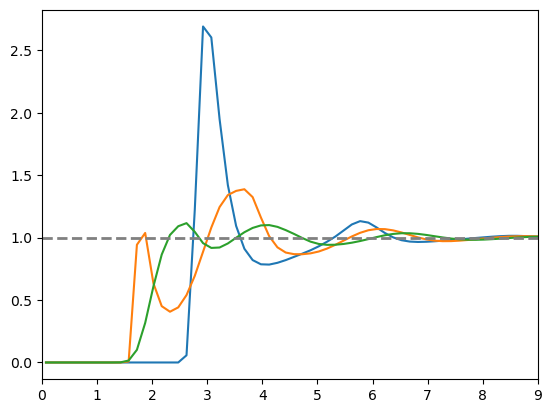

In [7]:
water_hr = water_tr + water_cr

water_gr = water_hr + 1.0

plt.plot(r_grid, water_gr[:, 0, 0])
plt.plot(r_grid, water_gr[:, 0, 1])
plt.plot(r_grid, water_gr[:, 1, 1])
plt.axhline(1, color="grey", linestyle="--", linewidth=2)
plt.xlim([0, 9])
plt.show()

### Solutes

As stated before, the solute-solvent problem is a simple extension of what we already have. It requires implementing a new integral equation and some new functions for handling solute-solvent interactions but they're roughly the same as what we've done ebfore.

First we need to pick a solute to test. We'll use methane, just because we can get a good symmetry reduction on that (the 4 hydrogens are equivalent sites). Note that we need to track all the coordinates of the 4 hydrogens.

In [8]:
nsu = 2

c_eps = 55.05221691240736 * kB
c_sigma = 1.6998347542253702
c_charge = -0.1088

h_eps = 7.900546687705287 * kB
h_sigma = 1.324766393630111
h_charge = 0.026699999999999998


methane_mult = np.diag([1.0, 4.0])
methane_params = [ [c_eps, c_sigma, c_charge], [h_eps, h_sigma, h_charge] ]
methane_coords = [ 
    np.array([3.537, 1.423, 0.0]), 
    np.array([4.089, 2.224, 0.496]), 
    np.array([4.222, 0.611, -0.254]),
    np.array([2.759, 1.049, 0.669]),
    np.array([3.077, 1.81, -0.912]),
]


We're specifically solving the problem under the assumption of infinite dilution - meaning we're considering only a single solute molecule present in the solvent.
The solute-solvent integral equation in this case is (accounting for the symmetry reduced direct correlation function) $$h_{uv} = w_u C (w_v + \rho h_{vv})$$

where $u$ indicates solute, and $v$ indicates solvent. $uv$ and $vv$ are the solute-solvent and solvent-solvent problems respectively.

This can be implemented almost directly in the way it's expressed mathematically.

In [9]:
def uv_RISM(cr, vk_lr, wu, wv, hvv, n, p, r, k, dr, dk):
    N = r.shape[0]
    
    tk = np.zeros_like(cr)
    # Transform c(r) to c(k)
    ck = fbt(cr, r, k, dr)

    ck -= vk_lr

    # Solve the RISM equation for t(k)
    for l in np.arange(0, N):
        tk[l] = wu[l] @ (n @ ck[l] @ n) @ (wv[l] + p @ hvv[l]) - ck[l]
    
    tk -= vk_lr
    
    # Transform t(k) to t(r)
    tr = ifbt(tk, r, k, dk)
    return tr

def uv_picard_iteration(tolerance, max_step, alpha, initial_tr, beta, ur_sr, uk_lr,  wk, rho, mult, wv, hvv):
    # Set up our loop variable tr
    tr = initial_tr
    
    # Define our counter
    step = 0
    
    while True:
        # Store previous t(r)
        tr_prev = tr

        # t(r) -> c(r) from closure
        cr = HNC(beta, ur_sr, tr)

        # c(r) -> F(t(r)) from RISM equation
        f_tr = uv_RISM(cr, beta * uk_lr, wk, wv, hvv, mult, rho, r_grid, k_grid, dr, dk)

        # Use Picard iteration to get the new solution
        # Since we set alpha = 1.0 above, this is 
        # essentially direct iteration (tr_new = f_tr).
        tr_new = alpha * f_tr + (1.0 - alpha) * tr_prev

        # Check the absolute value of the difference between the current and previous solution
        # We use .max() because we want to check that all values are below the tolerance, and
        # if the maximum value of the difference array is below, then so must the other values be.
        diff = np.sqrt(np.power((tr_new - tr_prev), 2).sum() * dr)

        # Set t(r) to the new t(r) we just computed
        tr = tr_new

        # Print the iteration step every 100 steps and difference
        if step % 100 == 0:
            print("Iteration: {step} Diff: {diff:.2e}".format(step=step, diff=diff))

        # Test if the difference is below our tolerance
        if diff < tolerance:
            print("Final Iteration: {step} Diff: {diff:.2e}".format(step=step, diff=diff))
            break
        
        # If we reach max_step, raise an error!
        if step == max_step:
            print("Reached max steps!")
            break

        if np.any(np.isnan(tr)):
            print("Diverged at iteration: {step}".format(step=step))
            break

        # Update our step counter. We have a max_step because we don't want this calculation to go 
        # on forever and freeze our PC.
        step += 1
    
    # Return solved t(r)
    return tr


We also need to write `energy` and `renorm` functions specifically for solute-solvent interactions - essentially a function that accounts for two different sets of parameters rather than iterating over the one set of parameters.

In [10]:
def uv_energy(solute_params, solvent_params, r, N, nsu, nsv):
    out = np.zeros((N, nsu, nsv))
    for i, j in np.ndindex((nsu, nsv)):
        eps, sig = lorentz_berthelot(
            solute_params[i][0], solvent_params[j][0], solute_params[i][1], solvent_params[j][1]
        )
        q = solute_params[i][2] * solvent_params[j][2]
        out[:, i, j] = LJ(eps, sig, r) + Coulomb(q, r)

    return out

def uv_renorm(solute_params, solvent_params, r, k, N, nsu, nsv):
    out_r = np.zeros((N, nsu, nsv))
    out_k = np.zeros((N, nsu, nsv))
    for i, j in np.ndindex((nsu, nsv)):
        q = solute_params[i][2] * solvent_params[j][2]
        out_r[:, i, j] = Ng_real(q, r)
        out_k[:, i, j] = Ng_fourier(q, k)

    return out_r, out_k

methane_wk = wk(methane_coords, methane_mult, k_grid, N, nsu)
methane_ur = uv_energy(methane_params, water_params, r_grid, N, nsu, nsv)
methane_ur_lr, methane_uk_lr = uv_renorm(methane_params, water_params, r_grid, k_grid, N, nsu, nsv)
methane_ur_sr = methane_ur - methane_ur_lr

Solving the solute-solvent problem takes the same form as the solvent-solvent problem numerically.

In [11]:
tolerance = 1e-7
max_step = 10000
alpha = 0.1
initial_tr = np.zeros((N, nsu, nsv))
lambdas = 1

for ilam in range(1, lambdas+1):
    lam = ilam / lambdas
    print(lam)
    tr = uv_picard_iteration(tolerance, max_step, alpha, initial_tr, beta, lam * methane_ur_sr, lam * methane_uk_lr, methane_wk, rho, water_mult, water_wk, water_hr)
    initial_tr = tr


methane_cr = HNC(beta, methane_ur_sr, tr) - beta * methane_ur_lr
methane_tr = tr + beta * methane_ur_lr

1.0
Iteration: 0 Diff: 1.56e+00
Iteration: 100 Diff: 3.15e-02
Iteration: 200 Diff: 1.86e-02
Iteration: 300 Diff: 1.53e-02
Iteration: 400 Diff: 1.27e-02
Iteration: 500 Diff: 1.06e-02
Iteration: 600 Diff: 8.85e-03
Iteration: 700 Diff: 7.42e-03
Iteration: 800 Diff: 6.22e-03
Iteration: 900 Diff: 5.23e-03
Iteration: 1000 Diff: 4.40e-03
Iteration: 1100 Diff: 3.70e-03
Iteration: 1200 Diff: 3.12e-03
Iteration: 1300 Diff: 2.63e-03
Iteration: 1400 Diff: 2.22e-03
Iteration: 1500 Diff: 1.87e-03
Iteration: 1600 Diff: 1.58e-03
Iteration: 1700 Diff: 1.33e-03
Iteration: 1800 Diff: 1.12e-03
Iteration: 1900 Diff: 9.47e-04
Iteration: 2000 Diff: 7.99e-04
Iteration: 2100 Diff: 6.75e-04
Iteration: 2200 Diff: 5.70e-04
Iteration: 2300 Diff: 4.81e-04
Iteration: 2400 Diff: 4.06e-04
Iteration: 2500 Diff: 3.43e-04
Iteration: 2600 Diff: 2.89e-04
Iteration: 2700 Diff: 2.44e-04
Iteration: 2800 Diff: 2.06e-04
Iteration: 2900 Diff: 1.74e-04
Iteration: 3000 Diff: 1.47e-04
Iteration: 3100 Diff: 1.24e-04
Iteration: 3200 

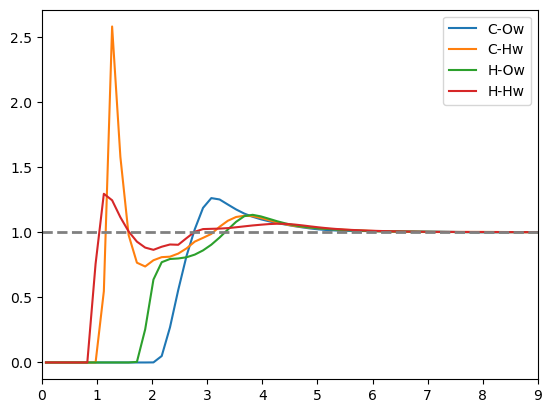

In [12]:
methane_hr = methane_tr + methane_cr

methane_gr = methane_hr + 1.0

plt.plot(r_grid, methane_gr[:, 0, 0], label='C-Ow')
plt.plot(r_grid, methane_gr[:, 0, 1], label='C-Hw')
plt.plot(r_grid, methane_gr[:, 1, 0], label='H-Ow')
plt.plot(r_grid, methane_gr[:, 1, 1], label='H-Hw')
plt.axhline(1, color="grey", linestyle="--", linewidth=2)
plt.xlim([0, 9])
plt.legend()
plt.show()